# Forecasting Regional Influenza Activity Using Global Panel Models
>Time Series Forecasting Project

**Objective**

In this project we build short-term forecasting models for weekly influenza-like illness (ILI%) in all ten U.S. HHS regions.

The idea is to move from a reactive approach (“we wait and see what happens”) to a more predictive one. Using historical surveillance data, we want to forecast flu activity by region and compare different modelling families:

- simple baselines,
- classical time-series models (SARIMA),
- and a modern global machine-learning model (Random Forest).

The final goal is to see which approach works best when the system is stressed by events like COVID and changing flu seasons.

## Problem Statement

Seasonal influenza is a recurring pressure on the healthcare system. It affects:

- hospital admissions and bed capacity,
- staff availability,
- vaccine demand and public communication.

Our main question is:

> Can we forecast next-week ILI% for each U.S. HHS region using historical flu surveillance data and a few key exogenous drivers?

We treat this as a **panel forecasting problem**:  
the target is weekly regional ILI% (ILI_PERCENT) and we use:

- past ILI%,
- lab positivity (PERCENT_POSITIVE),
- and time indicators (week of year, year, seasonal encodings)

to predict **one week ahead**.

## Dataset Description

## Dataset Overview

The dataset is a merged panel of weekly influenza surveillance for:

- **10 U.S. HHS regions**
- Weekly frequency
- From **October 1997 to November 2025**

Each row is one region–week pair. After cleaning and feature creation we have a long, balanced panel with many flu seasons per region.

Key variables:

- **ILI_PERCENT** – % of outpatient visits due to flu-like illness  
- **PERCENT_POSITIVE**, **TOTAL_SPECIMENS**, **TOTAL_A**, **TOTAL_B** – lab-confirmed activity  
- **DATE**, **YEAR**, **WEEKOFYEAR** – calendar structure  
- **REGION**, **REGION_ID** – region labels and numeric ID for ML

Overall, the data give us a rich history of flu seasons across regions, suitable for both per-region time-series models and global models trained on all regions together.

---

## Data Quality and Missing Values

Before modelling we checked missingness and basic data quality.

- Age-specific ILI variables had high and uneven missingness across years and regions, so we dropped them and worked with aggregate indicators instead.
- For lab variables such as **PERCENT_POSITIVE**, missingness was moderate and mostly in early years. We interpolated these values within each region to keep the time series smooth.
- Core variables for modelling (ILI_PERCENT, specimen counts, patient totals) are complete after these steps.

Dates were converted to proper datetime, and we verified that each region has a continuous weekly series with no duplicate region–week rows. ILI% is already a percentage, so we did not scale it further to keep the interpretation simple.


---

## **Data Import & Memory Optimization**

In [ ]:
# --- Installations ---
!pip install -q keras-tuner missingno plotly seaborn matplotlib scikit-learn tensorflow joblib pyarrow fsspec shap optuna catboost duckdb numpy

# --- Core Python & Utilities ---
import gc
import json
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # optional but used in EDA if needed

# --- Time-Series Tools ---
import statsmodels.api as sm

# --- Machine Learning ---
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# --- Missing Data Visualization ---
import missingno as msno

# --- Optional (if using LightGBM) ---
# import lightgbm as lgb

# --- System Settings ---
pd.set_option('display.max_columns', 200)
sns.set_style("whitegrid")


## 1. Data Exploration & Preparation

### 1.1 Load & Inspect Dataset

In [ ]:
df = pd.read_csv("flu_merged.csv", parse_dates=["DATE"])

In [ ]:
print(df.head())
print(df.dtypes)
print("\nRegions:", df["REGION"].unique())
print("\nTime span:", df["DATE"].min(), "→", df["DATE"].max())
print("\nWeekly frequency check (per region):")
print(df.groupby("REGION")["DATE"].agg(["min", "max", "count"]))

     REGION  YEAR  WEEK       DATE  TOTAL_SPECIMENS  TOTAL_A  TOTAL_B  \
0  Region 1  1997    40 1997-10-06               51      0.0      0.0   
1  Region 1  1997    41 1997-10-13               54      0.0      0.0   
2  Region 1  1997    42 1997-10-20               43      0.0      0.0   
3  Region 1  1997    43 1997-10-27               56      0.0      0.0   
4  Region 1  1997    44 1997-11-03               60      0.0      0.0   

   PERCENT_POSITIVE  PERCENT_A  PERCENT_B  REGION_TYPE  ILI_PERCENT  \
0               0.0        0.0        0.0  HHS Regions     0.498535   
1               0.0        0.0        0.0  HHS Regions     0.642669   
2               0.0        0.0        0.0  HHS Regions     2.899080   
3               0.0        0.0        0.0  HHS Regions     4.812500   
4               0.0        0.0        0.0  HHS Regions     1.371360   

   %UNWEIGHTED_ILI  AGE_0-4  AGE_25-49  AGE_25-64  AGE_5-24  AGE_50-64  \
0         0.623848       15        NaN        7.0        22 

### 1.2 Missing Values & Distribution Check

AGE_25-64             0.572597
AGE_50-64             0.362645
AGE_25-49             0.362645
PERCENT_POSITIVE      0.074710
PERCENT_A             0.074710
PERCENT_B             0.074710
REGION                0.000000
AGE_0-4               0.000000
NUM__OF_PROVIDERS     0.000000
ILI_TOTAL_PATIENTS    0.000000
AGE_65                0.000000
AGE_5-24              0.000000
ILI_PERCENT           0.000000
%UNWEIGHTED_ILI       0.000000
YEAR                  0.000000
REGION_TYPE           0.000000
TOTAL_B               0.000000
TOTAL_A               0.000000
TOTAL_SPECIMENS       0.000000
DATE                  0.000000
WEEK                  0.000000
TOTAL_PATIENTS        0.000000
dtype: float64


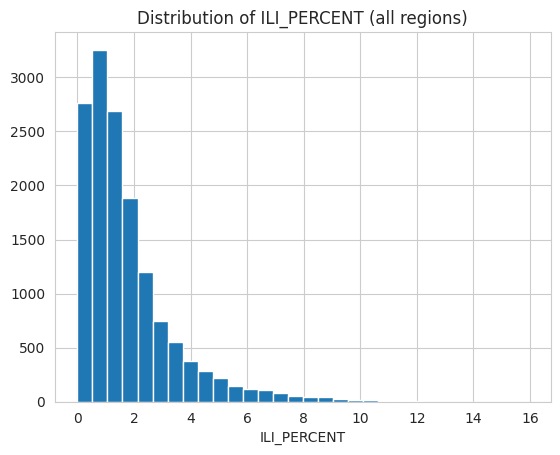

In [ ]:
# Missing values
na_ratio = df.isna().mean().sort_values(ascending=False)
print(na_ratio)

# Distribution check
df["ILI_PERCENT"].hist(bins=30)
plt.title("Distribution of ILI_PERCENT (all regions)")
plt.xlabel("ILI_PERCENT")
plt.show()


In [ ]:
age_cols = [c for c in df.columns if c.startswith("AGE_")]
df = df.drop(columns=age_cols)


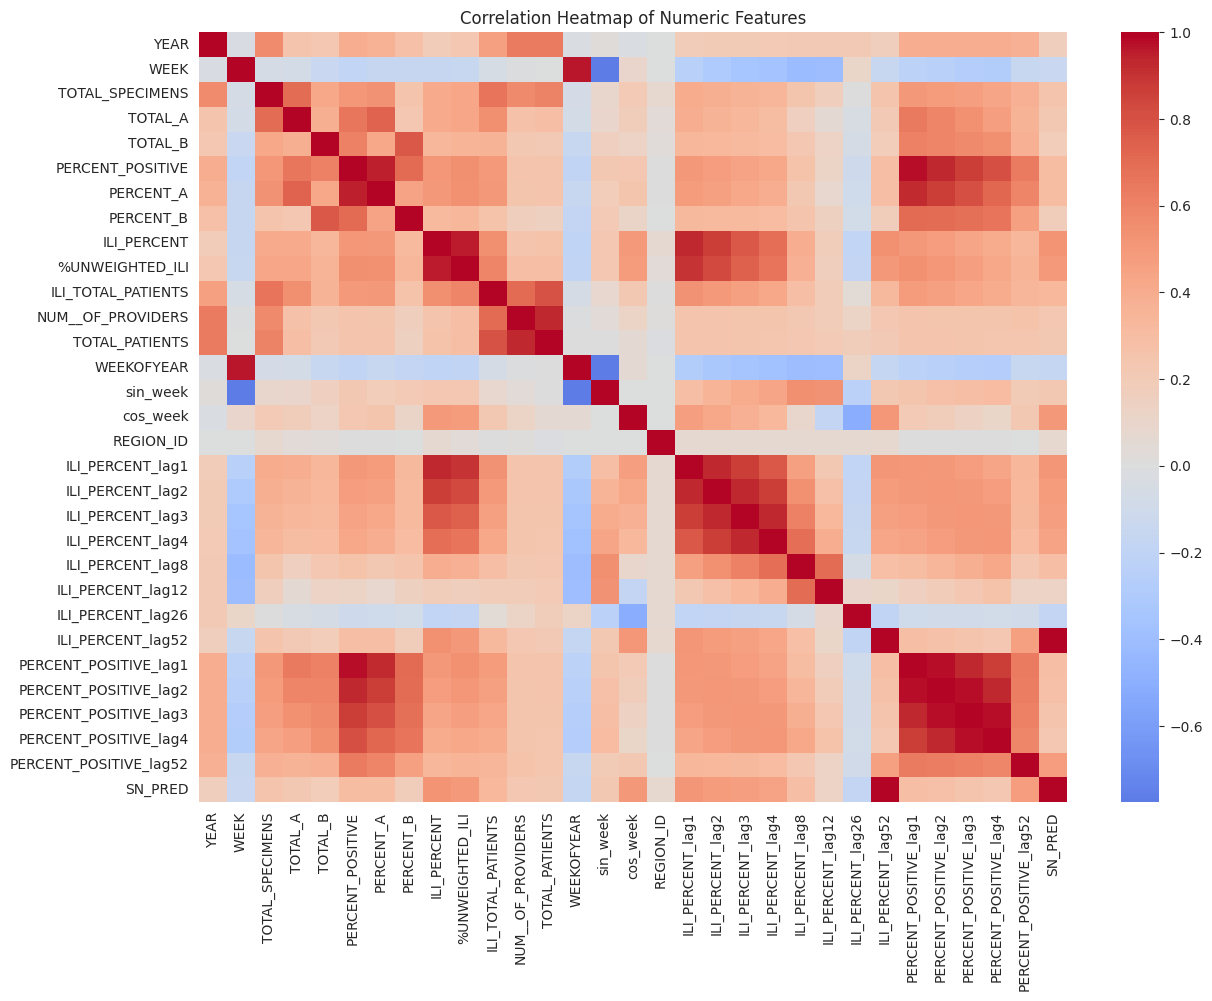

In [ ]:
plt.figure(figsize=(14, 10))

# keep only numeric columns
corr_matrix = df_model.select_dtypes(include=[np.number]).corr()

sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


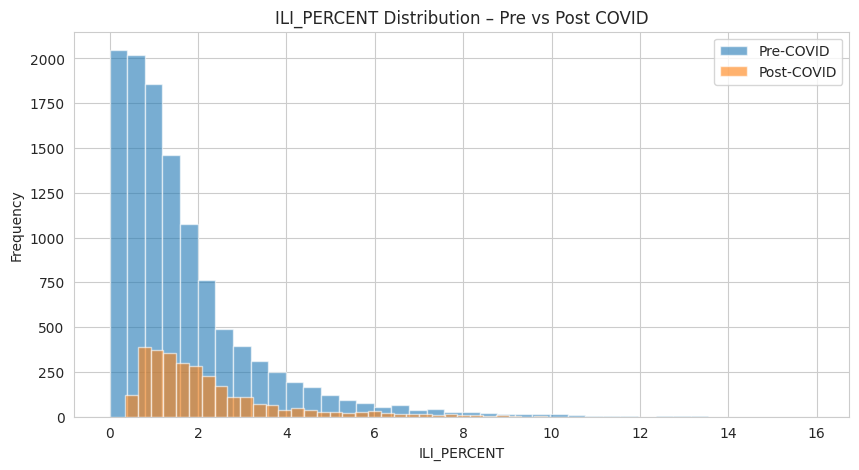

In [ ]:
pre_covid = df[df["DATE"] < "2020-03-01"]["ILI_PERCENT"]
post_covid = df[df["DATE"] >= "2020-03-01"]["ILI_PERCENT"]

plt.figure(figsize=(10,5))
plt.hist(pre_covid, bins=40, alpha=0.6, label="Pre-COVID")
plt.hist(post_covid, bins=40, alpha=0.6, label="Post-COVID")
plt.legend()
plt.title("ILI_PERCENT Distribution – Pre vs Post COVID")
plt.xlabel("ILI_PERCENT")
plt.ylabel("Frequency")
plt.show()


### 1.3 Time plots per region

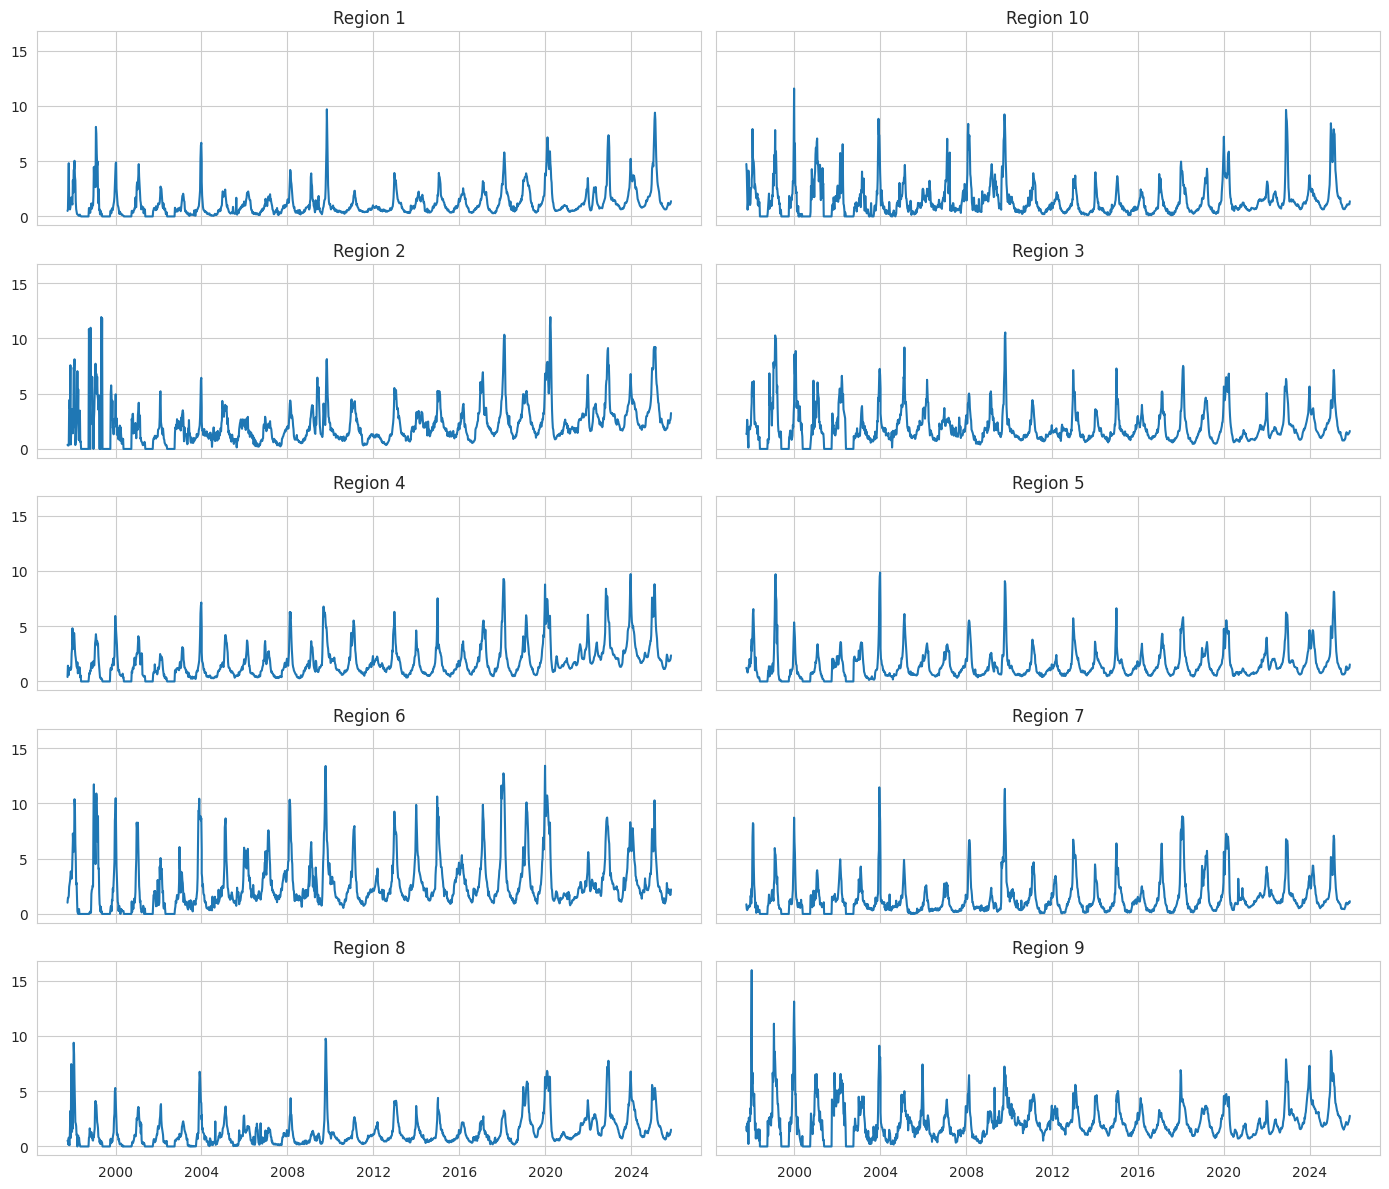

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(14, 12), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (region, rdf) in zip(axes, df.groupby("REGION")):
    rdf = rdf.sort_values("DATE")
    ax.plot(rdf["DATE"], rdf["ILI_PERCENT"])
    ax.set_title(region)
plt.tight_layout()
plt.show()

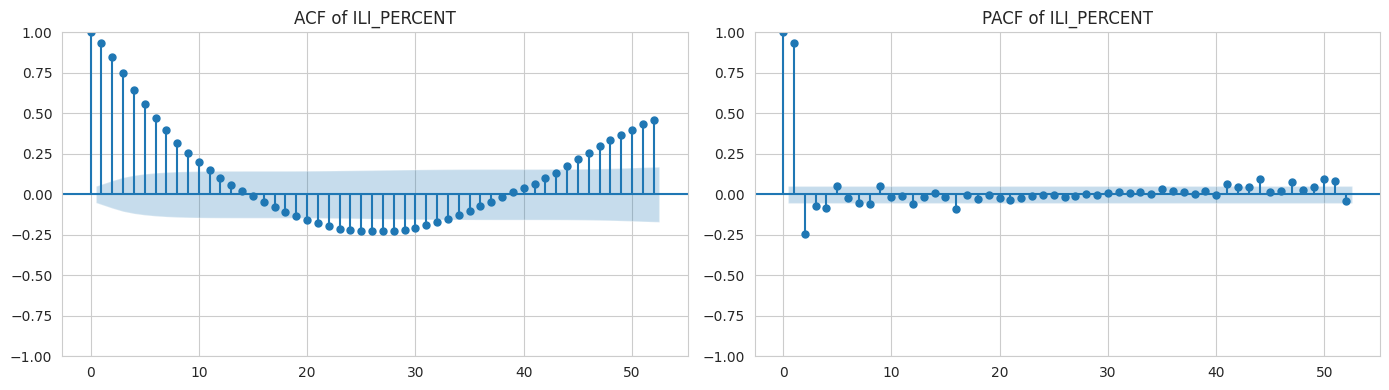

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

region = "Region 1"
reg_df = df[df["REGION"] == region].sort_values("DATE")

fig, axes = plt.subplots(1,2, figsize=(14,4))
plot_acf(reg_df["ILI_PERCENT"], ax=axes[0], lags=52)
axes[0].set_title("ACF of ILI_PERCENT")
plot_pacf(reg_df["ILI_PERCENT"], ax=axes[1], lags=52, method="ywm")
axes[1].set_title("PACF of ILI_PERCENT")
plt.tight_layout()
plt.show()


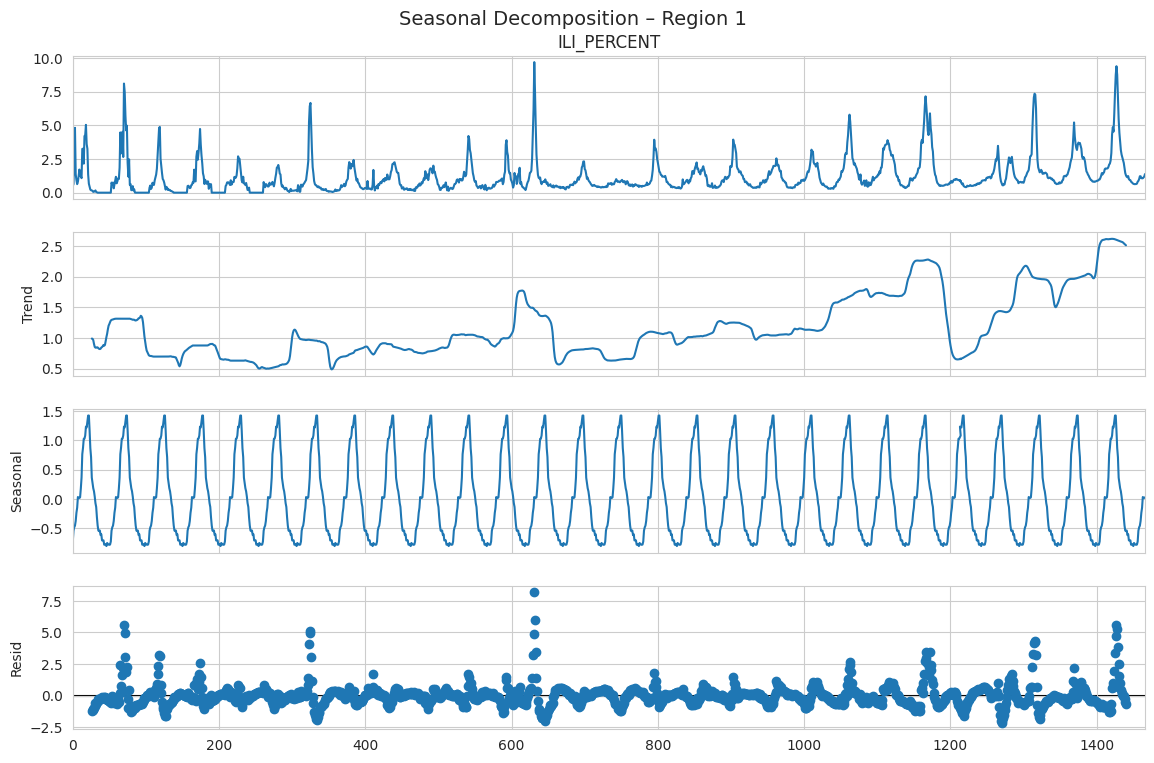

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

reg_df = df[df["REGION"] == "Region 1"].sort_values("DATE")
decomp = seasonal_decompose(reg_df["ILI_PERCENT"], model="additive", period=52)

fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Seasonal Decomposition – Region 1", fontsize=14)
plt.show()


## 2. Feature Engineering

### 2.1 Clean & Create Time Features

In [ ]:
hhs_mask = df["REGION"].astype(str).str.contains("Region")
df = df[hhs_mask].copy()


In [ ]:
age_cols = [c for c in df.columns if c.startswith("AGE_")]
df = df.drop(columns=age_cols)


In [ ]:
for c in ["PERCENT_POSITIVE", "PERCENT_A", "PERCENT_B"]:
    if c in df.columns:
        df[c] = df.groupby("REGION")[c].transform(
            lambda s: s.interpolate(limit_direction="both")
        )


In [ ]:
df["YEAR"] = df["DATE"].dt.year
df["WEEKOFYEAR"] = df["DATE"].dt.isocalendar().week.astype(int)

df["sin_week"] = np.sin(2 * np.pi * df["WEEKOFYEAR"] / 52.0)
df["cos_week"] = np.cos(2 * np.pi * df["WEEKOFYEAR"] / 52.0)


In [ ]:
df["REGION_CAT"] = df["REGION"].astype("category")
df["REGION_ID"] = df["REGION_CAT"].cat.codes


### 2.2 Lag Features

In [ ]:
def add_group_lags(df, group_col, target_col, lags):
    df = df.copy()
    for L in lags:
        df[f"{target_col}_lag{L}"] = df.groupby(group_col)[target_col].shift(L)
    return df

df = add_group_lags(df, "REGION", "ILI_PERCENT", [1,2,3,4,8,12,26,52])

if "PERCENT_POSITIVE" in df.columns:
    df = add_group_lags(df, "REGION", "PERCENT_POSITIVE", [1,2,3,4,52])


In [ ]:
df_model = df.dropna().reset_index(drop=True)


In [ ]:
df_model.head()
df_model.columns
df_model.shape


(14150, 34)

## 3. Train / Validation / Test Split (Time-Based)

In [ ]:
train_end = "2016-06-30"
val_end   = "2020-06-30"

train_mask = df_model["DATE"] <= train_end
val_mask   = (df_model["DATE"] > train_end) & (df_model["DATE"] <= val_end)
test_mask  = df_model["DATE"] > val_end

print(train_mask.sum(), val_mask.sum(), test_mask.sum())


9270 2080 2800


### 3.1 Feature Matrix

In [ ]:
target = "ILI_PERCENT"

feature_cols = [
    "REGION_ID",
    "WEEKOFYEAR", "sin_week", "cos_week",
    "PERCENT_POSITIVE", "TOTAL_SPECIMENS",
    "ILI_PERCENT_lag1", "ILI_PERCENT_lag2",
    "ILI_PERCENT_lag3", "ILI_PERCENT_lag4",
    "ILI_PERCENT_lag8", "ILI_PERCENT_lag12",
    "ILI_PERCENT_lag26", "ILI_PERCENT_lag52",
    "PERCENT_POSITIVE_lag1", "PERCENT_POSITIVE_lag2",
    "PERCENT_POSITIVE_lag3", "PERCENT_POSITIVE_lag4",
    "PERCENT_POSITIVE_lag52",
]

# Keep only those that exist (good safety check)
feature_cols = [c for c in feature_cols if c in df_model.columns]


In [ ]:
X_train = df_model.loc[train_mask, feature_cols]
y_train = df_model.loc[train_mask, target]

X_val   = df_model.loc[val_mask, feature_cols]
y_val   = df_model.loc[val_mask, target]

X_test  = df_model.loc[test_mask, feature_cols]
y_test  = df_model.loc[test_mask, target]

X_train.shape, X_val.shape, X_test.shape


((9270, 19), (2080, 19), (2800, 19))

In [ ]:
X_train.shape
X_val.shape
X_test.shape


(2800, 19)

## 4. Baseline Models


### 4.1 Metrics Helper

In [ ]:
def compute_metrics(y_true, y_pred):
    """Return MAE, RMSE, and MAPE metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    # Avoid division by zero in MAPE
    eps = 1e-9
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }

### 4.2 Naive & Seasonal Naive

In [ ]:
def naive_panel(df, trainval_mask, test_mask, target_col="ILI_PERCENT"):
    df = df.copy()
    preds = []

    boundary_date = df.loc[trainval_mask, "DATE"].max()
    last_vals = (
        df.loc[df["DATE"] <= boundary_date]
          .sort_values("DATE")
          .groupby("REGION")[target_col]
          .last()
    )

    for _, row in df.loc[test_mask].iterrows():
        preds.append(last_vals[row["REGION"]])

    return np.array(preds)

trainval_mask = df_model["DATE"] <= val_end
y_pred_naive = naive_panel(df_model, trainval_mask, test_mask)


In [ ]:
df_model["SN_PRED"] = (
    df_model.sort_values(["REGION", "DATE"])
            .groupby("REGION")[target]
            .shift(52)
)

y_pred_snaive = df_model.loc[test_mask, "SN_PRED"].values
valid_sn = ~np.isnan(y_pred_snaive)


In [ ]:


metrics_baselines = {
    "Naive": compute_metrics(y_test, y_pred_naive),
    "SeasonalNaive": compute_metrics(y_test[valid_sn], y_pred_snaive[valid_sn]),
}

pd.DataFrame(metrics_baselines).T


,MAE,RMSE,MAPE
Naive,1.294771,1.978649,47.412533
SeasonalNaive,1.086166,1.770939,65.243284


## 5. Classical Model: SARIMA

In [ ]:
regions = df_model["REGION"].unique()
sarima_preds = []
sarima_true  = []
sarima_regions = []

for region in regions:
    reg_df = df_model[df_model["REGION"] == region].sort_values("DATE")

    reg_trainval = reg_df[reg_df["DATE"] <= val_end]
    reg_test     = reg_df[reg_df["DATE"] > val_end]

    y_trainval = reg_trainval[target]

    model = sm.tsa.statespace.SARIMAX(
        y_trainval,
        order=(1, 0, 1),
        seasonal_order=(1, 1, 1, 52),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    fc = res.forecast(steps=len(reg_test))

    sarima_preds.extend(fc.values)
    sarima_true.extend(reg_test[target].values)
    sarima_regions.extend(reg_test["REGION"].values)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported inde

In [ ]:
sarima_preds = np.array(sarima_preds)
sarima_true  = np.array(sarima_true)

sarima_metrics = compute_metrics(sarima_true, sarima_preds)
sarima_metrics


{'MAE': 0.9938421138124834,
 'RMSE': 1.4500205284515975,
 'MAPE': 55.2411754638511}

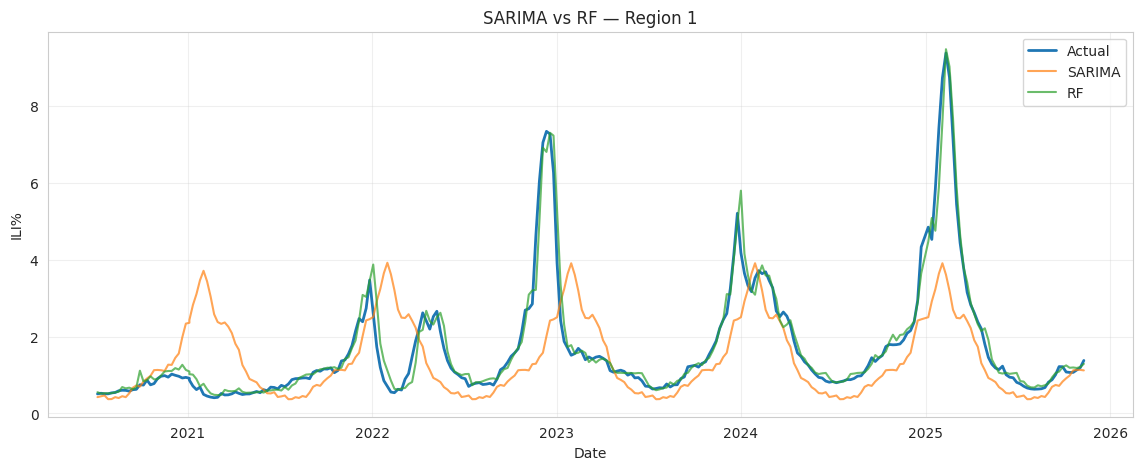

In [ ]:
region = "Region 1"
reg_sarima = pd.DataFrame({
    "DATE": df_model.loc[test_mask, "DATE"][df_model.loc[test_mask, "REGION"] == region],
    "SARIMA": sarima_preds[df_model.loc[test_mask, "REGION"] == region],
    "ILI": y_test[df_model.loc[test_mask, "REGION"] == region].values
})

reg_rf = reg_df  # already built in your notebook

plt.figure(figsize=(14,5))
plt.plot(reg_sarima["DATE"], reg_sarima["ILI"], label="Actual", linewidth=2)
plt.plot(reg_sarima["DATE"], reg_sarima["SARIMA"], label="SARIMA", alpha=0.7)
plt.plot(reg_rf["DATE"], reg_rf["RF_PRED"], label="RF", alpha=0.7)
plt.title("SARIMA vs RF — Region 1")
plt.xlabel("Date")
plt.ylabel("ILI%")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
